# Portfolio Notebook  
**Version:** 1.1.1  
**Last updated:** 2025‑05-06

In [13]:
import pandas as pd
import numpy as np
import yfinance as yf
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
import cvxpy as cp

sns.set_style("whitegrid")

import warnings
warnings.filterwarnings(
    "ignore",
    message="Parsing dates in"
)

In [14]:
# Ustalamy datę początkową i końcową (dziś)
start_date = "2022-05-01"
end_date = datetime.today().strftime('%Y-%m-%d')

# REPO

In [24]:
import os
print("Current working dir:", os.getcwd())

Current working dir: /Users/korneliakozaczewska/Desktop/chmurka/git


In [25]:
import os
os.chdir("/Users/korneliakozaczewska/Desktop/chmurka/git/fundusz-hossa-procapital")
print("Now in:", os.getcwd())

Now in: /Users/korneliakozaczewska/Desktop/chmurka/git/fundusz-hossa-procapital


## Portfel (korzystamy z pliku portolfio - transakcje)

In [26]:
# Czytamy dane z pliku z transakcjami
file_path = "/Users/korneliakozaczewska/Desktop/portfolio.xlsx"
df_tx = pd.read_excel(file_path, dtype=str)
#print(df_tx.head(10))

# Czytamy kolumny z pliku
if "Liczba akcji" in df_tx.columns:
    df_tx["Liczba akcji"] = df_tx["Liczba akcji"].str.replace(",", ".")
    df_tx["Liczba akcji"] = pd.to_numeric(df_tx["Liczba akcji"])
else:
    print("Brak Liczba akcji")    

if "Ticker" in df_tx.columns:
    df_tx["Ticker"] = (
        df_tx["Ticker"]
        .astype(str)
        .apply(lambda x: x.replace("WSE:", "") + ".WA" if x else x)
    )
else:
    print("Brak Ticker")

if "Data zrealizowania transakcji" in df_tx.columns:
    df_tx["Data"] = pd.to_datetime(df_tx["Data zrealizowania transakcji"], dayfirst=True, errors="coerce")
    df_tx = df_tx.sort_values("Data")
else:
    print("Brak Data")

if "Wartość kupna/sprzedaży" in df_tx.columns:
    df_tx["Wartość kupna/sprzedaży"] = (df_tx["Wartość kupna/sprzedaży"].str.replace(",", "."))
    df_tx["Wartość kupna/sprzedaży"] = pd.to_numeric(df_tx["Wartość kupna/sprzedaży"])
else:
    print("Brak Wartość kupna/sprzedaży")

if "Czynność" in df_tx.columns:
    df_tx["Czynność"] = df_tx["Czynność"].astype(str).str.strip()
else:
    print("Brak Czynność")

if "Wpłacona kwota" in df_tx.columns:
    df_tx["Wpłacona kwota"] = (df_tx["Wpłacona kwota"].str.replace(",", "."))
    df_tx["Wpłacona kwota"] = pd.to_numeric(df_tx["Wpłacona kwota"])
else:
    print("Brak Wpłacona kwota")

# Obliczamy gotówkę na podstawie wpłat + wartość transakcji sprzedazy - wartość transakcji kupna
cash = df_tx["Wpłacona kwota"].sum()
buy_spent = df_tx.loc[df_tx["Czynność"] == "BUY", "Wartość kupna/sprzedaży"].sum()
sell_income = df_tx.loc[df_tx["Czynność"] == "SELL", "Wartość kupna/sprzedaży"].sum()
current_cash = cash + sell_income - buy_spent

# Pokazujemy te kwoty + aktualny stan gotówki
print(f"\nTransakcje BUY: {buy_spent:.2f} PLN")
print(f"Transakcje SELL: {sell_income:.2f} PLN")
print(f"Aktualny stan gotówki (po transakcjach): {current_cash:.2f} PLN")

# Dla transakcji sell dajemy liczbę akcji z minusem
df_tx["Liczba akcji"] = df_tx.apply(
    lambda row: row["Liczba akcji"] if row["Czynność"] == "BUY" 
                else -row["Liczba akcji"] if row["Czynność"] == "SELL"
                else 0,
    axis=1
)

# Sumujemy liczbę akcji po tickerach
df_positions = df_tx.groupby("Ticker")["Liczba akcji"].sum()
df_positions = df_positions.drop("nan.WA", errors="ignore")

# "Spisujemy" posiadane tickery
tickers = df_positions.index.tolist()

# Ściągamy ceny zamknięcia posiadanych tickerów z yahoo finance dla podanego zakresu dat
price_data = yf.download(tickers, start=start_date, end=end_date)["Close"]
last_prices = price_data.iloc[-1] # Ostatnie ceny zamknięcia

# Spisujemy sobie dane do nowej ramki i obliczamy wartość posiadanych akcji
df_portfolio = pd.DataFrame(df_positions, columns=["Liczba akcji"])
df_portfolio["Liczba akcji"] = pd.to_numeric(df_portfolio["Liczba akcji"], errors="coerce").fillna(0)
df_portfolio["Ostatnia cena"] = df_portfolio.index.map(last_prices).fillna(0)
df_portfolio["Ostatnia cena"] = pd.to_numeric(df_portfolio["Ostatnia cena"], errors="coerce").fillna(0)
df_portfolio["Wartość"] = df_portfolio["Liczba akcji"] * df_portfolio["Ostatnia cena"]

# Dodajemy gotówkę do portfolio
df_portfolio.loc["GOTÓWKA", "Liczba akcji"] = np.nan
df_portfolio.loc["GOTÓWKA", "Ostatnia cena"] = np.nan
df_portfolio.loc["GOTÓWKA", "Wartość"] = current_cash

# Liczymy udział spółek/gotówki w portfelu
total_value = df_portfolio["Wartość"].sum()
if total_value != 0:
    df_portfolio["Udział %"] = (df_portfolio["Wartość"] / total_value) * 100
else:
    df_portfolio["Udział %"] = 0

# Pokazujemy całkowitą wartość portfela
print("\nPortfel - udział poszczególnych spółek (z uwzględnieniem gotówki i transakcji BUY/SELL):")
display(df_portfolio)
print(f"\nCałkowita wartość portfela: {total_value:.2f} PLN")

[*********************100%***********************]  9 of 9 completed


Transakcje BUY: 90000.00 PLN
Transakcje SELL: 0.00 PLN
Aktualny stan gotówki (po transakcjach): 10000.00 PLN

Portfel - udział poszczególnych spółek (z uwzględnieniem gotówki i transakcji BUY/SELL):


Liczba akcji  Ostatnia cena       Wartość   Udział %
Ticker                                                       
AMB.WA         440.53      21.700001   9559.501336   9.235338
ANR.WA         413.22      29.000000  11983.380000  11.577022
BFT.WA           3.43    3400.000000  11662.000000  11.266540
DOM.WA          50.51     230.000000  11617.300000  11.223356
NEU.WA          12.17     722.000000   8786.740000   8.488781
TXT.WA         168.63      55.599998   9375.827743   9.057892
VOX.WA          73.53     146.800003  10794.204224  10.428172
VRC.WA          84.39     115.599998   9755.483871   9.424674
WTN.WA         489.00      20.400000   9975.599813   9.637326
GOTÓWKA           NaN            NaN  10000.000000   9.660899


Całkowita wartość portfela: 103510.04 PLN


## Zapisujemy CSV do DOCS (PORTFEL)

In [ ]:
os.makedirs("docs", exist_ok=True)

df_portfolio.round(2).to_csv(
    "docs/summary.csv",
    index=True,
    sep=";",
    float_format="%.2f",
    decimal=","
)

## Dywidendy i splity

In [17]:
df_close = price_data.copy()
df_close.index = pd.to_datetime(df_close.index)
df_close.index = df_close.index.tz_localize(None)
df_close_date = df_close

# Dywidendy
df_div = pd.DataFrame()
for ticker in tickers:
    series = yf.Ticker(ticker).dividends.loc[start_date:end_date]
    df_div = pd.concat([df_div, series], axis=1)
df_div.columns = tickers

df_div.index = pd.to_datetime(df_div.index)
df_div.index = df_div.index.tz_localize(None)
df_div_date = df_div.reindex(df_close.index, fill_value=0)

# Splity
df_splits = pd.DataFrame()
for ticker in tickers:
    series = yf.Ticker(ticker).splits.loc[start_date:end_date]
    df_splits = pd.concat([df_splits, series], axis=1)
df_splits.columns = tickers

df_splits.index = pd.to_datetime(df_splits.index)
df_splits.index = df_splits.index.tz_localize(None)
df_splits_date = df_splits.reindex(df_close.index, fill_value=0)


# Liczone tak jak tutaj: https://help.yahoo.com/kb/SLN28256.html 

df_adj_close = df_close_date.copy()

for ticker in df_close_date.columns:
    factor = pd.Series(1.0, index=df_close_date.index)
    
    for i in range(1, len(df_close_date)):
        date = df_close_date.index[i]
        prev_date = df_close_date.index[i-1]
        
        # Dywidendy
        div = df_div_date.loc[date, ticker] if ticker in df_div_date.columns else 0
        day_factor_div = 1.0
        if pd.notna(div) and div != 0:
            price_before = df_close_date.loc[prev_date, ticker]
            day_factor_div = 1.0 - (div / price_before)
        
        # Splity
        split = df_splits_date.loc[date, ticker] if ticker in df_splits_date.columns else np.nan
        day_factor_split = 1.0
        if pd.notna(split) and split != 0:
            day_factor_split = 1.0 / split
        
        day_factor = day_factor_div * day_factor_split
        factor.iloc[:i] = factor.iloc[:i] * day_factor
    
    df_adj_close[ticker] = df_close_date[ticker] * factor
    
display(df_adj_close)

Ticker         AMB.WA     ANR.WA       BFT.WA      DOM.WA      NEU.WA  \
Date                                                                    
2022-05-02  16.169725  23.600000   513.128971   48.753915  661.752326   
2022-05-04  16.017178  24.600000   502.900484   46.728997  681.695626   
2022-05-05  16.017178  25.000000   501.195755   49.325050  652.687284   
2022-05-06  15.940905  23.549999   470.510266   45.482886  683.021309   
2022-05-09  15.635818  22.350000   501.195755   44.184859  653.976527   
...               ...        ...          ...         ...         ...   
2025-04-28  21.400000  28.500000  3205.000000  214.500000  725.000000   
2025-04-29  21.350000  28.700001  3270.000000  220.000000  729.000000   
2025-04-30  21.350000  28.750000  3260.000000  219.500000  712.000000   
2025-05-02  21.450001  28.900000  3380.000000  225.000000  732.000000   
2025-05-05  21.700001  29.000000  3400.000000  230.000000  722.000000   

Ticker         TXT.WA      VOX.WA      VRC.WA     WTN.WA  
Date                                                      
2022-05-02  64.536016   29.073173   37.304390   9.248004  
2022-05-04  65.923891   28.627032   38.721014   9.292679  
2022-05-05  65.715704   27.883476   38.437690   8.935269  
2022-05-06  65.923891   27.139919   38.815455   8.756564  
2022-05-09  64.536016   26.024578   38.626574   8.935269  
...               ...         ...         ...        ...  
2025-04-28  53.099998  143.000000  115.800003  20.500000  
2025-04-29  53.849998  144.399994  118.599998  20.400000  
2025-04-30  54.000000  144.199997  116.000000  20.299999  
2025-05-02  56.250000  147.600006  117.400002  20.400000  
2025-05-05  55.599998  146.800003  115.599998  20.400000  

[752 rows x 9 columns]

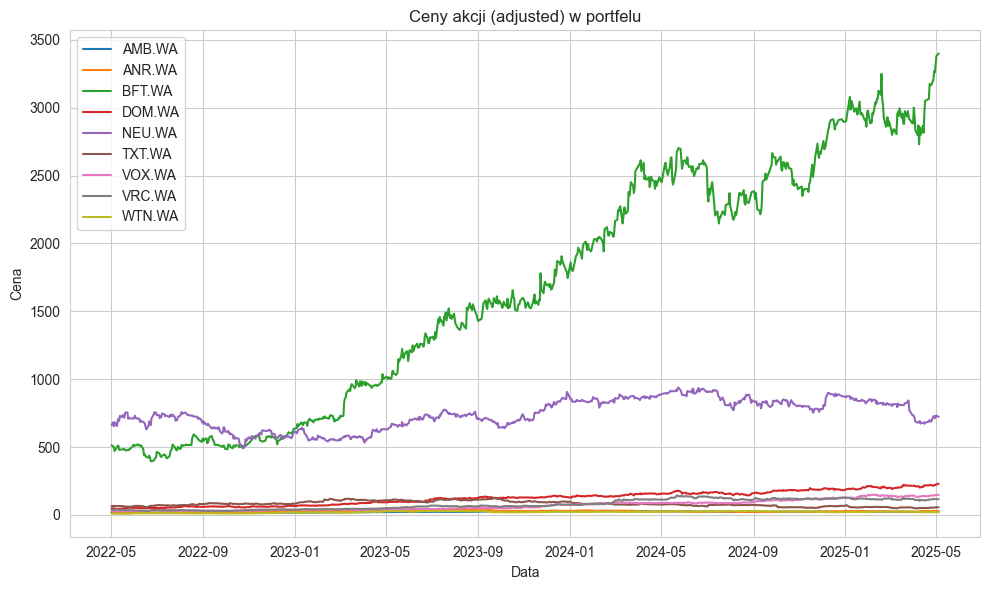

In [18]:
plt.figure(figsize=(10,6))
for col in df_adj_close.columns:
    plt.plot(df_adj_close.index, df_adj_close[col], label=col)
plt.title("Ceny akcji (adjusted) w portfelu")
plt.xlabel("Data")
plt.ylabel("Cena")
plt.legend()
plt.tight_layout()
plt.show()

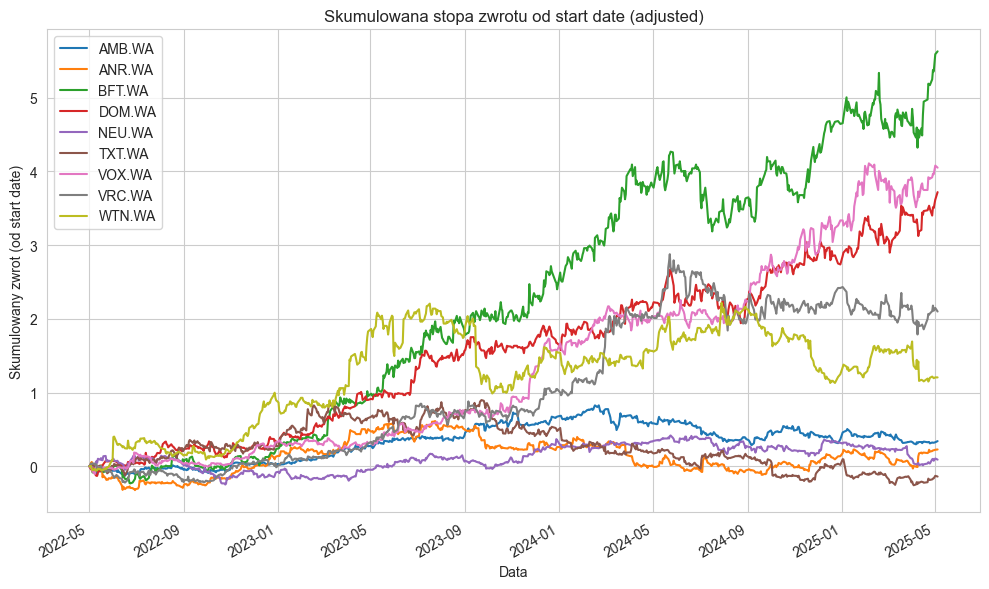

In [19]:
# Obliczamy skumulowaną stopę zwrotu od pierwszego dnia
cumulative_returns_df = (df_adj_close / df_adj_close.iloc[0]) - 1

plt.figure(figsize=(10,6))
cumulative_returns_df.plot(ax=plt.gca())

plt.title("Skumulowana stopa zwrotu od start date (adjusted)")
plt.xlabel("Data")
plt.ylabel("Skumulowany zwrot (od start date)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


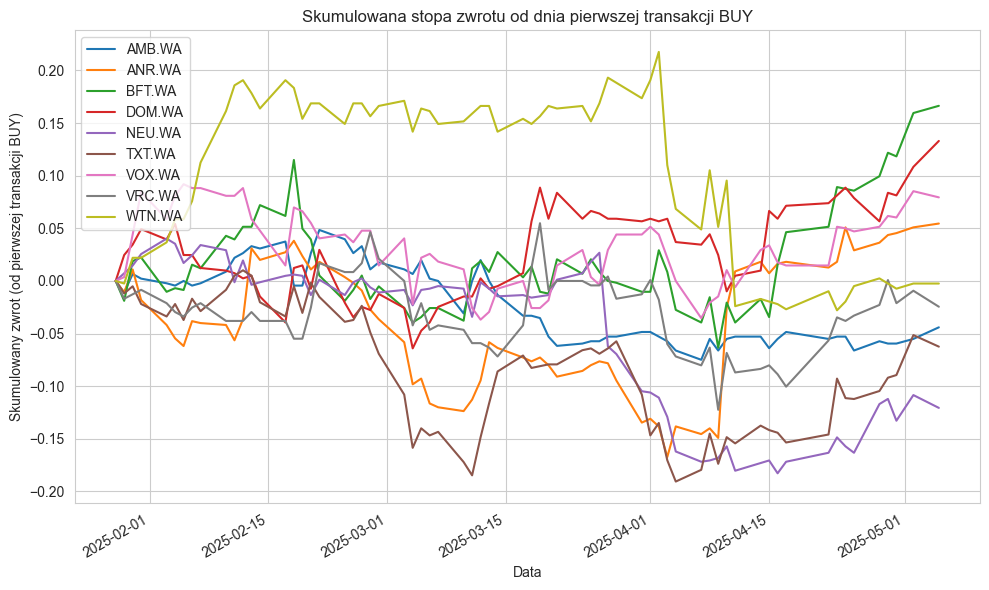

In [20]:
# Skumulowana stopa zwrotu spółek od dnia pierwszej transakcji BUY
first_buy_date = df_tx.loc[df_tx["Czynność"] == "BUY", "Data"].min()

cumulative_returns_from_buy = (df_adj_close.loc[first_buy_date:] / df_adj_close.loc[first_buy_date]) - 1

plt.figure(figsize=(10, 6))
cumulative_returns_from_buy.plot(ax=plt.gca())

plt.title("Skumulowana stopa zwrotu od dnia pierwszej transakcji BUY")
plt.xlabel("Data")
plt.ylabel("Skumulowany zwrot (od pierwszej transakcji BUY)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


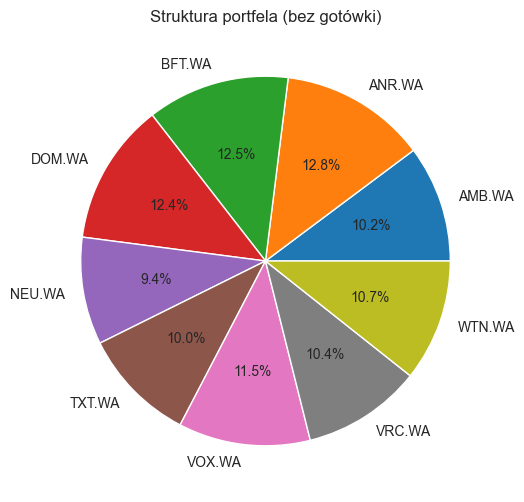

In [21]:
df_stocks_only = df_portfolio.drop("GOTÓWKA", errors="ignore")
plt.figure(figsize=(6,6))
plt.pie(df_stocks_only["Wartość"], labels=df_stocks_only.index, autopct="%1.1f%%")
plt.title("Struktura portfela (bez gotówki)")
plt.show()

## Funkcje wskaźników ryzyka

In [22]:
# Tworzymy funkcje dla wskaźników ryzyka
def calculate_var(series, confidence=0.95):
    """
    Przyjmujemy, że VaR na poziomie 95% to 5-ty percentyl strat (negatywne zwroty)
    """
    return np.percentile(series, (1 - confidence) * 100)
    
def calculate_cvar(series, confidence=0.95):
    var = calculate_var(series, confidence)
    return series[series <= var].mean()

def max_drawdown(returns: pd.Series) -> float:
    """
    Oblicza maksymalne obsunięcie kapitału przy użyciu prostych stóp zwrotu.
    Zwraca wartość w przedziale [-1, 0], np. -0.30 oznacza -30%.
    """
    cumulative = (1 + returns).cumprod()
    rolling_max = cumulative.cummax()
    drawdown = (cumulative / rolling_max) - 1.0
    mdd_fraction = drawdown.min()
    return mdd_fraction

def beta(portfolio_returns: pd.Series, benchmark_returns: pd.Series) -> float:
    """
    Liczy Betę portfela względem benchmarku:
    Beta = Cov(Rp, Rb) / Var(Rb).
    """
    df_temp = pd.DataFrame({
        "Rp": portfolio_returns,
        "Rb": benchmark_returns
    }).dropna()
    
    cov = np.cov(df_temp["Rp"], df_temp["Rb"])[0,1]
    var_bench = np.var(df_temp["Rb"])
    if var_bench == 0:
        return np.nan
    return cov / var_bench

## Benchmark

In [23]:
df_mwig = pd.read_csv("/Users/korneliakozaczewska/Desktop/mwig40tr_d.csv", sep=",", parse_dates=["Data"], dayfirst=False)
df_swig = pd.read_csv("/Users/korneliakozaczewska/Desktop/swig80tr_d.csv", sep=",", parse_dates=["Data"], dayfirst=False)


# Obliczamy proste stopy zwrotu
df_mwig["mwig_ret"] = df_mwig["Zamkniecie"].pct_change()
df_swig["swig_ret"] = df_swig["Zamkniecie"].pct_change()

# Łączymy w całość
df_bench = pd.merge(df_mwig, df_swig, on="Data", how="inner").sort_values("Data")
df_bench["benchmark_ret"] = 0.2 * df_bench["mwig_ret"] + 0.8 * df_bench["swig_ret"]

benchmark_returns = df_bench.set_index("Data")["benchmark_ret"].dropna()



FileNotFoundError: [Errno 2] No such file or directory: '/Users/korneliakozaczewska/Desktop/mwig40tr_d.csv'

## Ryzyko spółek

In [ ]:
# Obliczamy dzienne stopy zwrotu z danych historycznych
returns = (df_adj_close / df_adj_close.shift(1) - 1).dropna()
    
# Liczymy wskaźniki ryzyka dla kazdej spółki
risk_metrics = {}
for ticker in returns.columns:
    ticker_returns = returns[ticker]
    
    volatility = ticker_returns.std()
    var_95 = calculate_var(ticker_returns, confidence=0.95)
    cvar_95 = calculate_cvar(ticker_returns, confidence=0.95)
    
    beta_ticker = beta(ticker_returns, benchmark_returns)
    max_dd = max_drawdown(ticker_returns)

    risk_metrics[ticker] = {"Volatility": volatility, "VaR (95%)": var_95, "CVaR (95%)": cvar_95, "Beta": beta_ticker, "Max Drawdown": max_dd}
    
risk_df = pd.DataFrame(risk_metrics).T
print(risk_df)

        Volatility  VaR (95%)  CVaR (95%)      Beta  Max Drawdown
AMB.WA    0.016461  -0.023498   -0.033796  0.606629     -0.295031
ANR.WA    0.023471  -0.032953   -0.050902  0.773062     -0.451444
BFT.WA    0.025672  -0.033102   -0.048245  1.125753     -0.240984
DOM.WA    0.020567  -0.028004   -0.038606  0.875970     -0.199408
NEU.WA    0.019854  -0.030004   -0.042723  0.825467     -0.341584
TXT.WA    0.026802  -0.038298   -0.056625  0.921634     -0.608232
VOX.WA    0.019262  -0.026134   -0.036139  0.690952     -0.159899
VRC.WA    0.023358  -0.034573   -0.047401  1.159857     -0.266907
WTN.WA    0.027628  -0.033831   -0.052679  0.879339     -0.379947


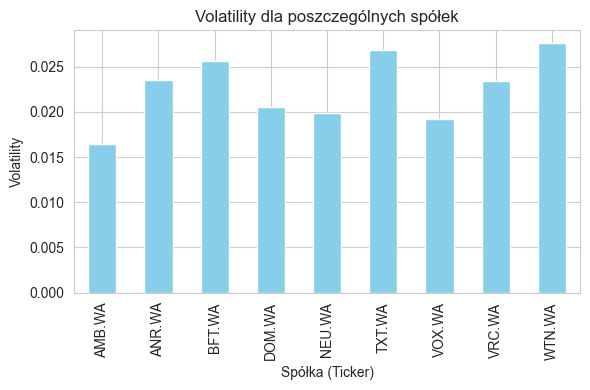

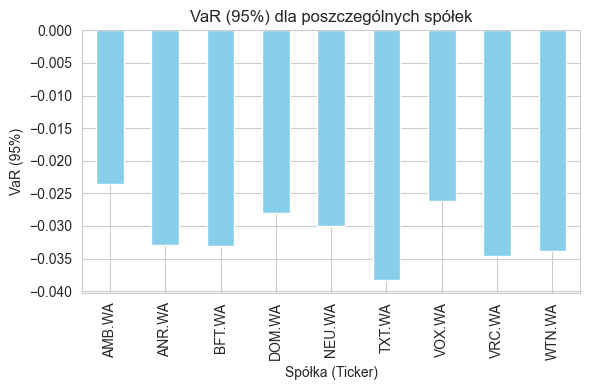

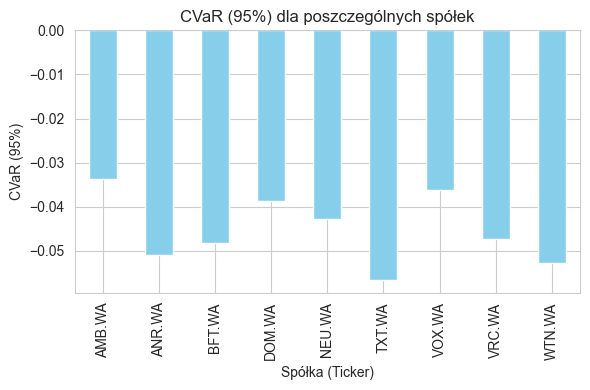

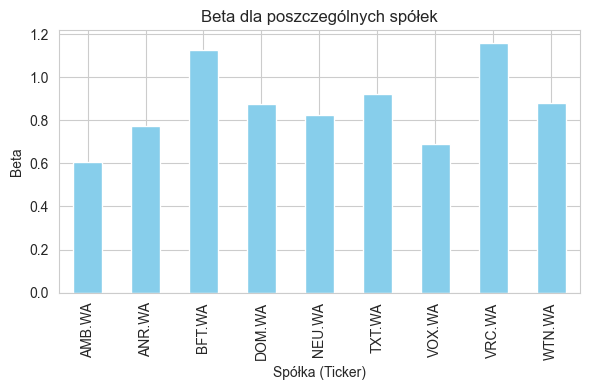

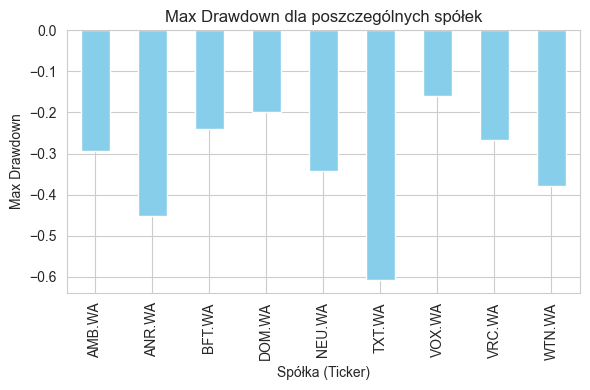

In [ ]:
risk_columns = ["Volatility", "VaR (95%)", "CVaR (95%)", "Beta", "Max Drawdown"]

for col in risk_columns:
    df_plot = risk_df[[col]].dropna()

    plt.figure(figsize=(6,4))
    df_plot.plot(kind="bar", legend=False, ax=plt.gca(), color="skyblue")
    plt.title(f"{col} dla poszczególnych spółek")
    plt.xlabel("Spółka (Ticker)")
    plt.ylabel(col)
    plt.tight_layout()
    plt.show()


## Ryzyko portfela

In [ ]:
# Obliczamy dzienne zwroty portfela jako średnią wazoną (wartością w portfelu) zwrotów poszczególnych spółek (bez gotówki)
df_stocks = df_portfolio.drop("GOTÓWKA", errors="ignore")
stock_weights = df_stocks["Wartość"] / df_stocks["Wartość"].sum()
portfolio_returns = (returns * stock_weights).sum(axis=1)
    
port_volatility = portfolio_returns.std()
port_var_95 = np.percentile(portfolio_returns, 5)
port_cvar_95 = portfolio_returns[portfolio_returns <= port_var_95].mean()

port_beta = beta(portfolio_returns, benchmark_returns)
port_max_dd = max_drawdown(portfolio_returns)

portfolio_risk = pd.DataFrame({
    "Volatility": [port_volatility],
    "VaR (95%)": [port_var_95],
    "CVaR (95%)": [port_cvar_95],
    "Beta": [port_beta],
    "Max Drawdown": [port_max_dd]
}, index=["Portfel"])

print("\nWskaźniki ryzyka dla portfela:")


Wskaźniki ryzyka dla portfela:


## Optymalizacja (korzystamy z pliku portfolio2 - wycenione) z kwadratami wag

In [ ]:
file_path = "/Users/korneliakozaczewska/Desktop/portfolio2.xlsx"
df_pf = pd.read_excel(file_path, dtype=str)

# Ściąganie danych
if "Cena docelowa" in df_pf.columns:
    df_pf["Cena docelowa"] = (df_pf["Cena docelowa"].str.replace(",", "."))
    df_pf["Cena docelowa"] = pd.to_numeric(df_pf["Cena docelowa"])
else:
    print("Brak Cena docelowa")

if "Sektor" not in df_pf.columns: print("Brak Sektor")

if "Ticker" in df_pf.columns:
    df_pf["Ticker"] = (
        df_pf["Ticker"]
        .astype(str)
        .apply(lambda x: x.replace("WSE:", "") + ".WA" if x else x)
    )
else:
    print("Brak Ticker")
    
df_pf = df_pf.set_index(df_pf["Ticker"])


# Ograniczenia i parametry
n_assets = len(df_pf["Ticker"])
max_assets = 5
min_weight = 0.05
max_sector_weight = 0.5
max_weight_square_sum = 0.25
#odchylenie standardowe portfela

# Dane
tickers_wycenione = df_pf["Ticker"]
valuation = df_pf["Cena docelowa"]
price = df_pf["Ticker"].map(last_prices)
volatility = df_pf["Ticker"].map(risk_df["Volatility"])
score = (valuation - price) / volatility
sectors = df_pf["Sektor"]
#odchylenie standasrdowe portfela z 3 lat

dane = pd.DataFrame({
    "Sector": sectors,
    "Wycena": valuation,
    "Cena": price,
    "Zmienność": volatility,
    "Score": score,
}, index=tickers_wycenione)
display(dane)

# Zmienne decyzyjne
w = cp.Variable(n_assets)
z = cp.Variable(n_assets, boolean=True)

# Ograniczenia
constraints = [
    cp.sum(w) == 1,
    w >= 0,
    w <= z,
    cp.sum(z) <= max_assets,
    cp.sum_squares(w) <= max_weight_square_sum
]

for i in range(n_assets):
    constraints.append(w[i] >= min_weight * z[i])

for sector in set(sectors):
    idx = [i for i in range(n_assets) if sectors[i] == sector]
    constraints.append(cp.sum(w[idx]) <= max_sector_weight)

# Funkcja celu
objective = cp.Maximize(score.values @ w)
problem = cp.Problem(objective, constraints)

# Rozwiązanie
problem.solve(solver=cp.ECOS_BB)  # bo mamy zmienne binarne

result = problem.solve(solver=cp.ECOS_BB)
print("Status problemu:", problem.status)
print("Optimal value:", problem.value)

# Wyniki
df_wyniki = pd.DataFrame({
    "Waga": np.round(w.value, 4),
    "W portfelu": z.value > 0.5
}, index=tickers_wycenione)

df = pd.concat([dane, df_wyniki], axis=1)
display(df.sort_values(by='Waga', ascending=False))

Sector   Wycena         Cena  Zmienność         Score
Ticker                                                                       
DOM.WA             Real Estate   242.29   212.000000   0.020567   1472.717860
ANR.WA  Consumer Discretionary    39.80    23.650000   0.023471    688.091940
NEU.WA             Health Care  1066.14   681.000000   0.019854  19398.436121
VRC.WA  Information Technology   145.00   111.000000   0.023358   1455.576721
WTN.WA  Consumer Discretionary    29.20    22.600000   0.027628    238.885366
TXT.WA  Information Technology    91.75    50.700001   0.026802   1531.628728
BFT.WA  Consumer Discretionary  3990.10  2870.000000   0.025672  43630.345644
AMB.WA        Consumer Staples    31.52    21.450001   0.016461    611.752038
VOX.WA             Health Care   170.00   133.199997   0.019262   1910.521044

/var/folders/tx/9g_s4rm56clg1s64hp55l8tw0000gn/T/ipykernel_3520/1427736759.py:69: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  idx = [i for i in range(n_assets) if sectors[i] == sector]


Status problemu: optimal
Optimal value: 21849.490623308004


Sector   Wycena         Cena  Zmienność         Score  \
Ticker                                                                          
BFT.WA  Consumer Discretionary  3990.10  2870.000000   0.025672  43630.345644   
NEU.WA             Health Care  1066.14   681.000000   0.019854  19398.436121   
VOX.WA             Health Care   170.00   133.199997   0.019262   1910.521044   
TXT.WA  Information Technology    91.75    50.700001   0.026802   1531.628728   
DOM.WA             Real Estate   242.29   212.000000   0.020567   1472.717860   
ANR.WA  Consumer Discretionary    39.80    23.650000   0.023471    688.091940   
VRC.WA  Information Technology   145.00   111.000000   0.023358   1455.576721   
WTN.WA  Consumer Discretionary    29.20    22.600000   0.027628    238.885366   
AMB.WA        Consumer Staples    31.52    21.450001   0.016461    611.752038   

          Waga  W portfelu  
Ticker                      
BFT.WA  0.3818        True  
NEU.WA  0.2352        True  
VOX.WA  0.1293        True  
TXT.WA  0.1270        True  
DOM.WA  0.1267        True  
ANR.WA  0.0000       False  
VRC.WA  0.0000       False  
WTN.WA  0.0000       False  
AMB.WA  0.0000       False

### 1)  Poprawić model optymalizacyjny + uzupełnić w polityce inwestycyjnej:
1. 12 spółek z upsidem 20%
2. wzór ale przez odchylenie standardowe spółki, porządkujemy od największej i 12 spółek wrzucamy do modelu
3. ten wzór / odch. stand. zmiennych zmian ceny z ostatnich trzech lat z takimi wagami jak w liczniku >>> maksymalnie dla spółki 20%

### 2)  Sprawdzamy ograniczenia bez kwadratów wag
Być może warto zacząć od prostego modelu, a potem stopniowo dodawać kolejne parametry i obserwować, co się dzieje z portfelem.
Alternatywnie można użyć metod scenariuszowych lub stochastycznych (np. generować różne warianty możliwych zmian i szukać portfela, który w miarę dobrze radzi sobie w każdym scenariuszu).

### 3)   Sprawdzamy wrazliwość wag na zmiany w dcf
Może przy tych dcfach spróbujmy zobaczyć po prostu jak się zmieniają wagi portfela, ale pod takim kątem, żeby mały procent zmiany dcf nie zmieniał nam diametralnie wag w portfelu, skoro są one obarczone jakimś błędem. I jeśli zmienia bardzo to będziemy kombinować z ograniczeniami

### 4) Porównać dzienne stopy zwrotu, a tygodniowe stopy zwrotu w odchyleniu standardowym